In [1]:
import PIL.ImageOps
import torch
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, transforms

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
transform = transforms.Compose([transforms.Resize((28, 28)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

training_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

In [4]:
# training_loader = torch.utils.data.DataLoader(dataset=training_dataset, batch_size=100, shuffle=True)
training_loader = torch.utils.data.DataLoader(dataset=training_dataset, batch_size=100, shuffle=True, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100)

In [5]:
# def im_convert(tensor):
#     image = tensor.clone().detach().numpy()
#     image = image.transpose(1, 2, 0)
#     image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
#     image = image.clip(0, 1)
#     return image

In [6]:
# Corrected im_convert function
def im_convert(tensor):
    if tensor.is_cuda:
        tensor = tensor.cpu()
    image = tensor.clone().detach().numpy()
    image = image.transpose(1, 2, 0)
    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
    return image


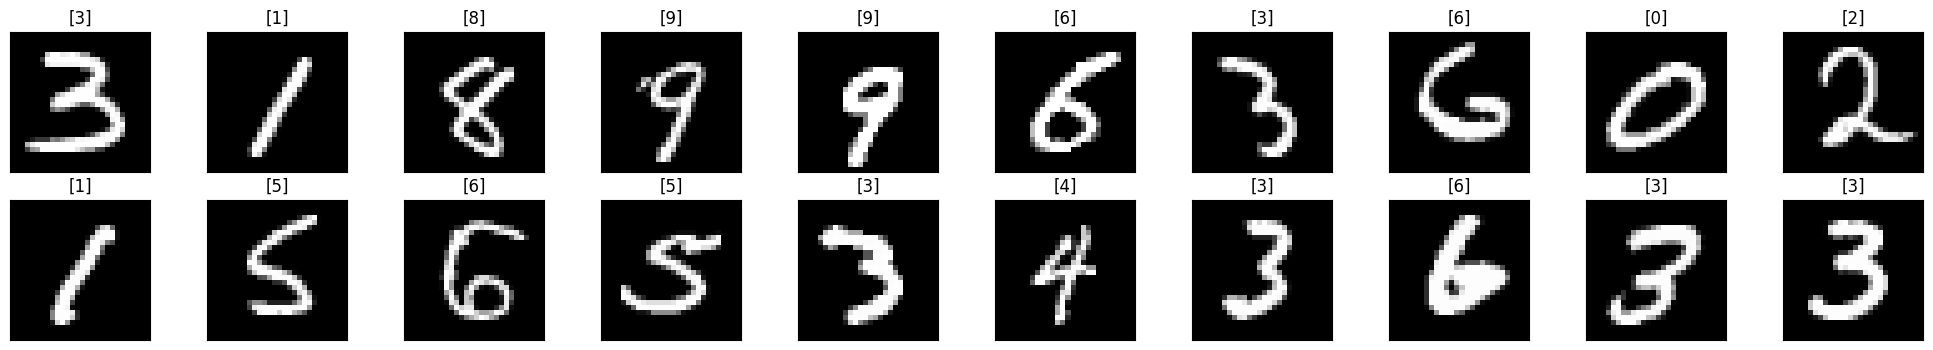

In [7]:
dataiter = iter(training_loader)
images, labels = next(dataiter)
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx + 1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx]))
    ax.set_title([labels[idx].item()])

In [8]:
 class Classifier(nn.Module):
    def __init__(self, D_in, H1, H2, D_out):
        super().__init__()
        self.linear1 = nn.Linear(D_in, H1)
        self.linear2 = nn.Linear(H1, H2)
        self.linear3 = nn.Linear(H2, D_out)

    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x

In [9]:
model = Classifier(784, 125, 65, 10).to(device)
model

Classifier(
  (linear1): Linear(in_features=784, out_features=125, bias=True)
  (linear2): Linear(in_features=125, out_features=65, bias=True)
  (linear3): Linear(in_features=65, out_features=10, bias=True)
)

In [10]:
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [11]:
# epochs = 15
# running_loss_history = []
# running_corrects_history = []
# 
# test_running_loss_history = []
# test_running_corrects_history = []
# 
# for e in range(epochs):
# 
#     running_loss = 0.0
#     running_corrects = 0.0
# 
#     test_running_loss = 0.0
#     test_running_corrects = 0.0
# 
#     for inputs, labels in training_loader:
#         
#         inputs = inputs.to(device)
#         labels = labels.to(device)
# 
#         inputs = inputs.view(inputs.shape[0], -1)
#         outputs = model(inputs)
#         loss = criterion(outputs, labels)
# 
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
# 
#         _, preds = torch.max(outputs, 1)
# 
#         running_loss += loss.item()
#         running_corrects += torch.sum(preds == labels.data)
# 
# 
#     else:
#         with torch.no_grad():
#             for test_inputs, test_labels in test_loader:
#                 
#                 test_inputs = inputs.to(device)
#                 test_labels = labels.to(device)
#                 
#                 test_inputs = test_inputs.view(test_inputs.shape[0], -1)
#                 test_outputs = model(test_inputs)
#                 test_loss = criterion(test_outputs, test_labels)
# 
#                 _, test_preds = torch.max(test_outputs, 1)
#                 test_running_loss += test_loss.item()
#                 test_running_corrects += torch.sum(test_preds == test_labels.data)
# 
#         epoch_loss = running_loss / len(training_loader)
#         epoch_accuracy = running_corrects.float() / len(training_loader)
# 
#         running_loss_history.append(epoch_loss)
#         running_corrects_history.append(epoch_accuracy)
#         # ==========================//test//======================
#         test_epoch_loss = test_running_loss / len(test_loader)
#         test_epoch_accuracy = test_running_corrects.float() / len(test_loader)
# 
#         test_running_loss_history.append(test_epoch_loss)
#         test_running_corrects_history.append(test_epoch_accuracy)
# 
#         print(f'epoch {e + 1}')
#         print('training loss:{:.4f}, accuracy {:.4f}'.format(epoch_loss, epoch_accuracy.item()))
#         print('test loss:{:.4f}, test accuracy {:.4f}'.format(test_epoch_loss, test_epoch_accuracy.item()))

In [12]:
# plt.plot(running_loss_history, label='training loss')
# plt.plot(test_running_loss_history, label='test loss')
# plt.legend()

In [13]:
# # Assuming running_corrects_history is a list of PyTorch tensors
# # Convert and move tensors to CPU and then convert to NumPy arrays
# running_corrects_history_numpy = [tensor.cpu().numpy() for tensor in running_corrects_history]
# test_running_corrects_history_numpy = [tensor.cpu().numpy() for tensor in test_running_corrects_history]
# 
# plt.plot(running_corrects_history_numpy, label='accuracy')
# plt.plot(test_running_corrects_history_numpy, label='test accuracy')


In [14]:
# # saving the model
# 
# model_path = './trained-model/first-model'
# torch.save(model.state_dict(), model_path)

In [15]:
# loading the model
model = Classifier(784, 125, 65, 10).to(device)
model_path = './trained-model/first-model'
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

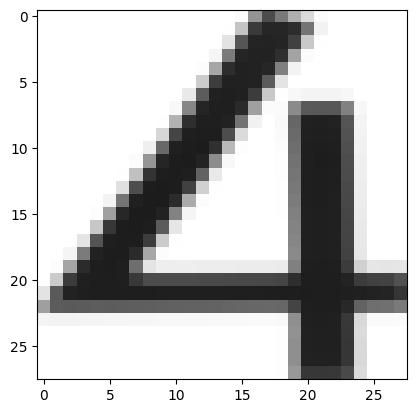

In [21]:
import requests
from PIL import Image
import PIL.ImageOps

url = 'https://m.media-amazon.com/images/I/61SGLu-zNQL._AC_SY355_.jpg'

response = requests.get(url, stream=True)
img = Image.open(response.raw)

img = img.convert('L')
# img = PIL.ImageOps.invert(img)
img = transform(img)
plt.imshow(im_convert(img))

In [22]:
img = img.to(device)
img = img.view(img.shape[0], -1)
test_outputs = model(img)
_, pred = torch.max(test_outputs, 1)

print(pred.item())

7


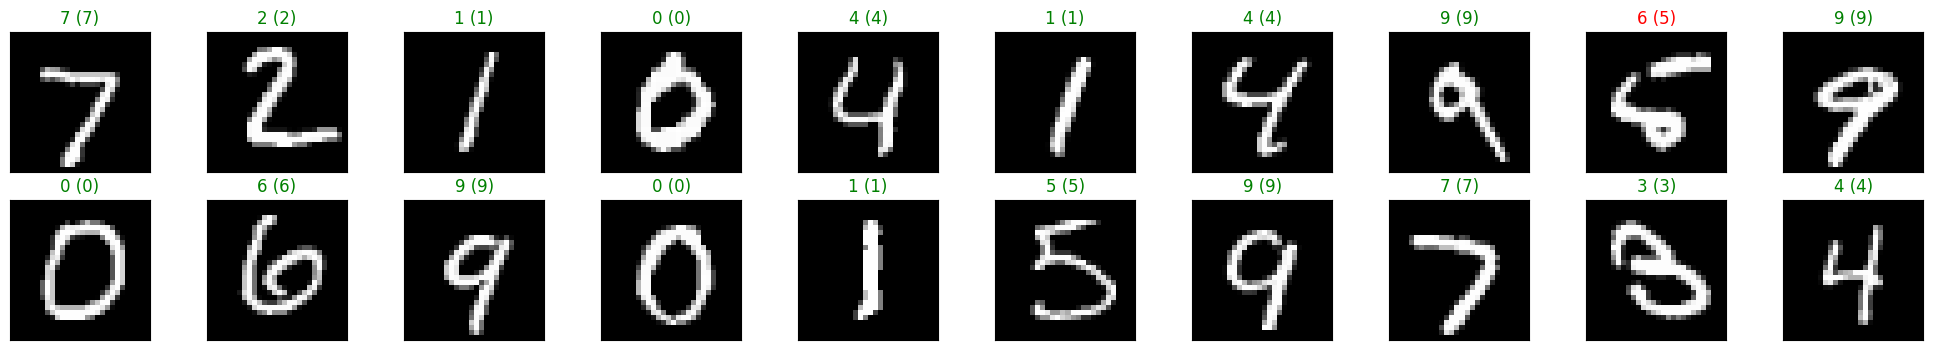

In [20]:
dataiter = iter(test_loader)
images, labels = next(dataiter)

images = images.to(device)

images_ = images.view(images.shape[0], -1)
output = model(images_)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(25, 4))

# running_corrects_history_numpy = [tensor.cpu().numpy() for tensor in running_corrects_history]


for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx + 1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx]))
    ax.set_title(
        "{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
        color=('green' if preds[idx] == labels[idx] else "red"))